In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libs

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Load data

In [7]:
ROOT_PATH_DATA = '/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/'
train_full = pd.read_pickle(ROOT_PATH_DATA + 'create_feature_train_ver2.pkl')

temp, test = train_test_split(train_full, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209107, 534), (52277, 534), (46127, 534))

# Funcs

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1

    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.plot([0, 1], [0, 1], '--', color = 'blue')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def plotImp(model , num = 20, fig_size = (45, 25), font_scale = 4):
#     print(len(model.feature_importance()))
#     print(len(X.columns))
    feature_imp = pd.DataFrame({'Value':model.feature_importance(importance_type = 'gain'),
                                'Feature':model.feature_name()})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = font_scale)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

# LGBM-ver1

In [ ]:
lgb_train = lgb.Dataset(data=train.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train.TARGET)
lgb_valid = lgb.Dataset(data=valid.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid.TARGET)
lgb_test = lgb.Dataset(data=test.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test.TARGET)

In [ ]:
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
          'learning_rate': 0.01,
          'num_leaves': 20,
          'max_bin': 20,
          'num_iteration': 1000,
          'colsample_bytree':.8,
          'subsample':.9,
          'max_depth':7,
          'reg_alpha':.1,
          'reg_lambda':.1,
          'min_split_gain':.01,
          'min_child_weight':1}

lgb_ver1 = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

[LightGBM] [Info] Number of positive: 16842, number of negative: 192265
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.547351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9457
[LightGBM] [Info] Number of data points in the train set: 209107, number of used features: 527
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080542 -> initscore=-2.434999
[LightGBM] [Info] Start training from score -2.434999
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.746525	valid_1's auc: 0.74247
[100]	training's auc: 0.75461	valid_1's auc: 0.748713
[150]	training's auc: 0.762489	valid_1's auc: 0.754941
[200]	training's auc: 0.769266	valid_1's auc: 0.760219
[250]	training's auc: 0.775628	valid_1's auc: 0.765372
[300]	training's auc: 0.781297	valid_1's auc: 0.769847
[350]	training's auc: 0.785768	valid_1's auc: 0.773178
[400]	training's auc: 0.789678	valid_1's auc: 0.775938
[4

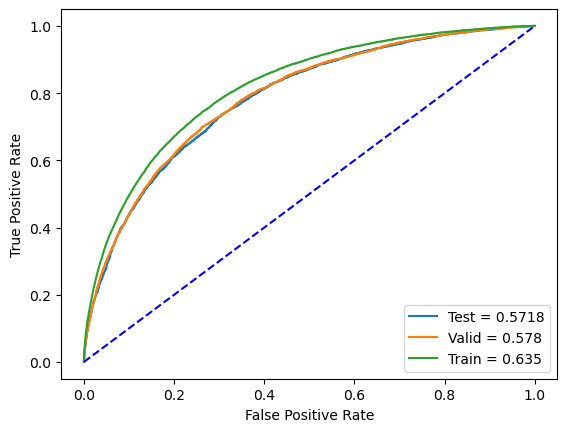

In [ ]:
pred_test = lgb_ver1.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_valid = lgb_ver1.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_train = lgb_ver1.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']),
               y_prob = (pred_test, pred_valid, pred_train))

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': lgb_ver1.feature_name(),
        'importance': lgb_ver1.feature_importance('gain'),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance.sort_values(by = 'importance', ascending=False)

,feature,importance
120,APPS_EXT_SOURCE_MEAN,417323.492845
41,EXT_SOURCE_3,34179.706059
123,APPS_GOODS_CREDIT_RATIO,27273.730509
523,CARD_M3BALANCE_LIMIT_RATIO_MAX,25270.191669
40,EXT_SOURCE_2,20197.420412
...,...,...
263,BUREAU_ACT_CREDIT_DAY_OVERDUE_MIN_x,0.000000
94,FLAG_DOCUMENT_2,0.000000
403,POS_M20POS_IS_DPD_OVER_120_MEAN,0.000000
202,PREV_D365_PREV_GOODS_DIFF_MAX,0.000000


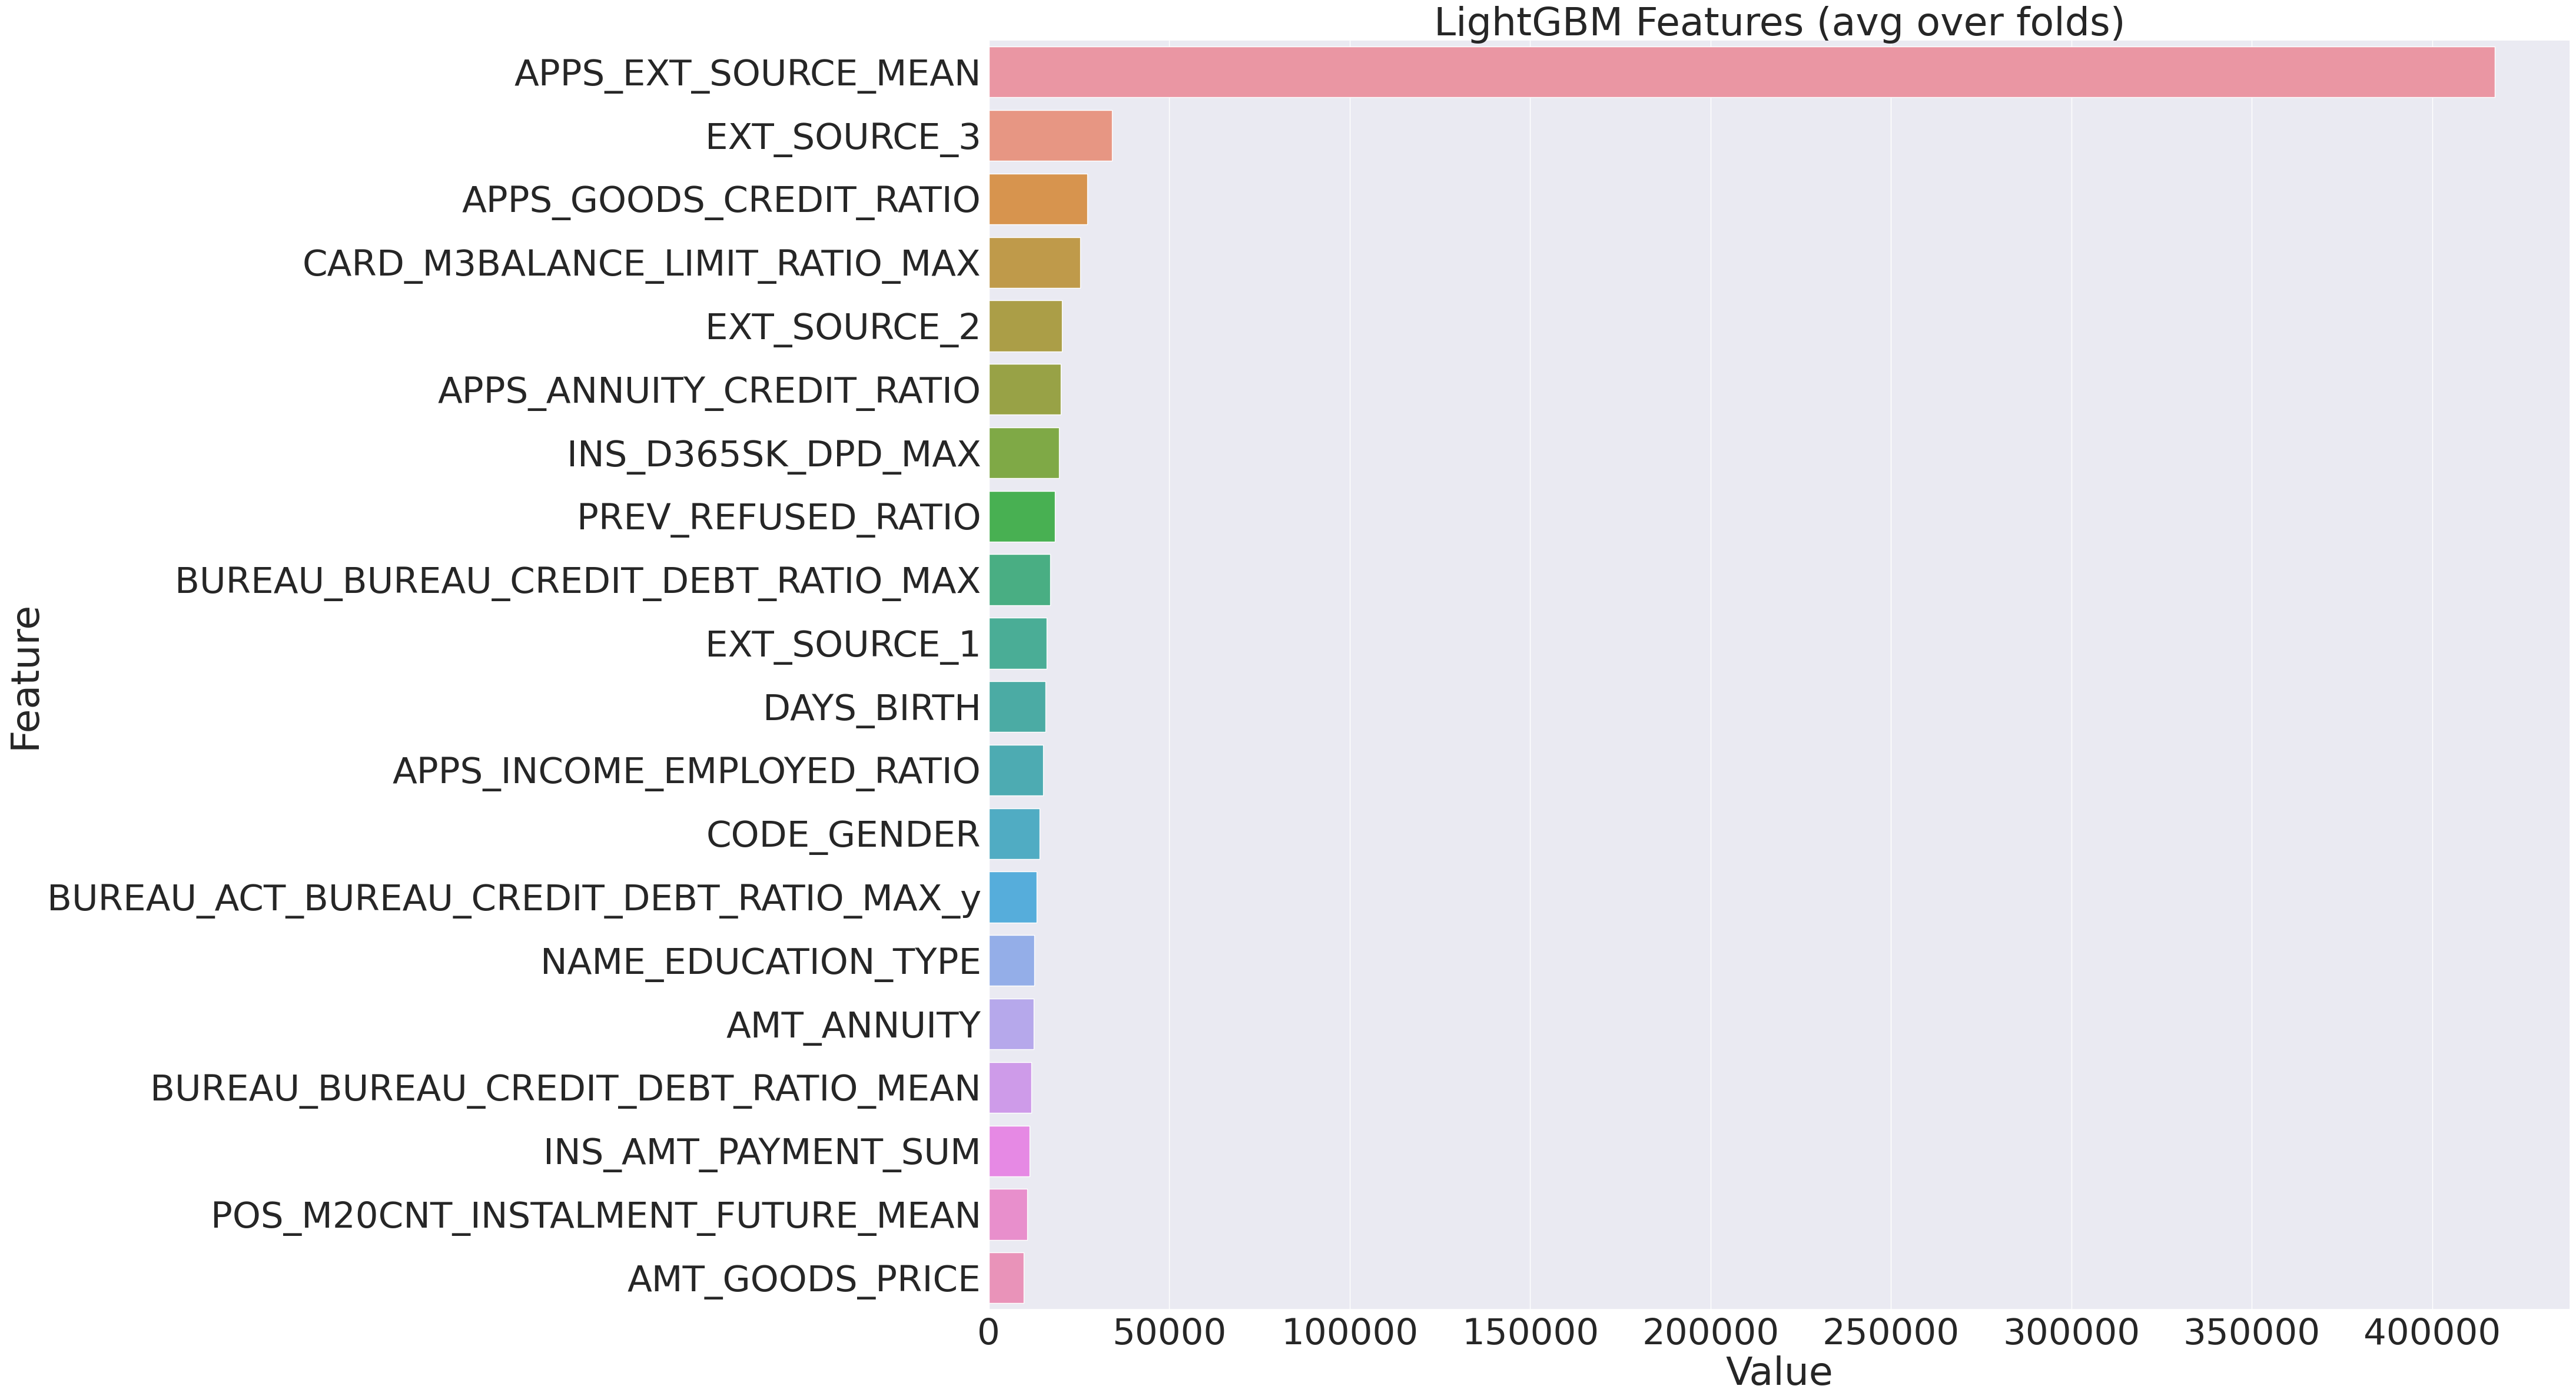

In [ ]:
plotImp(lgb_ver1)

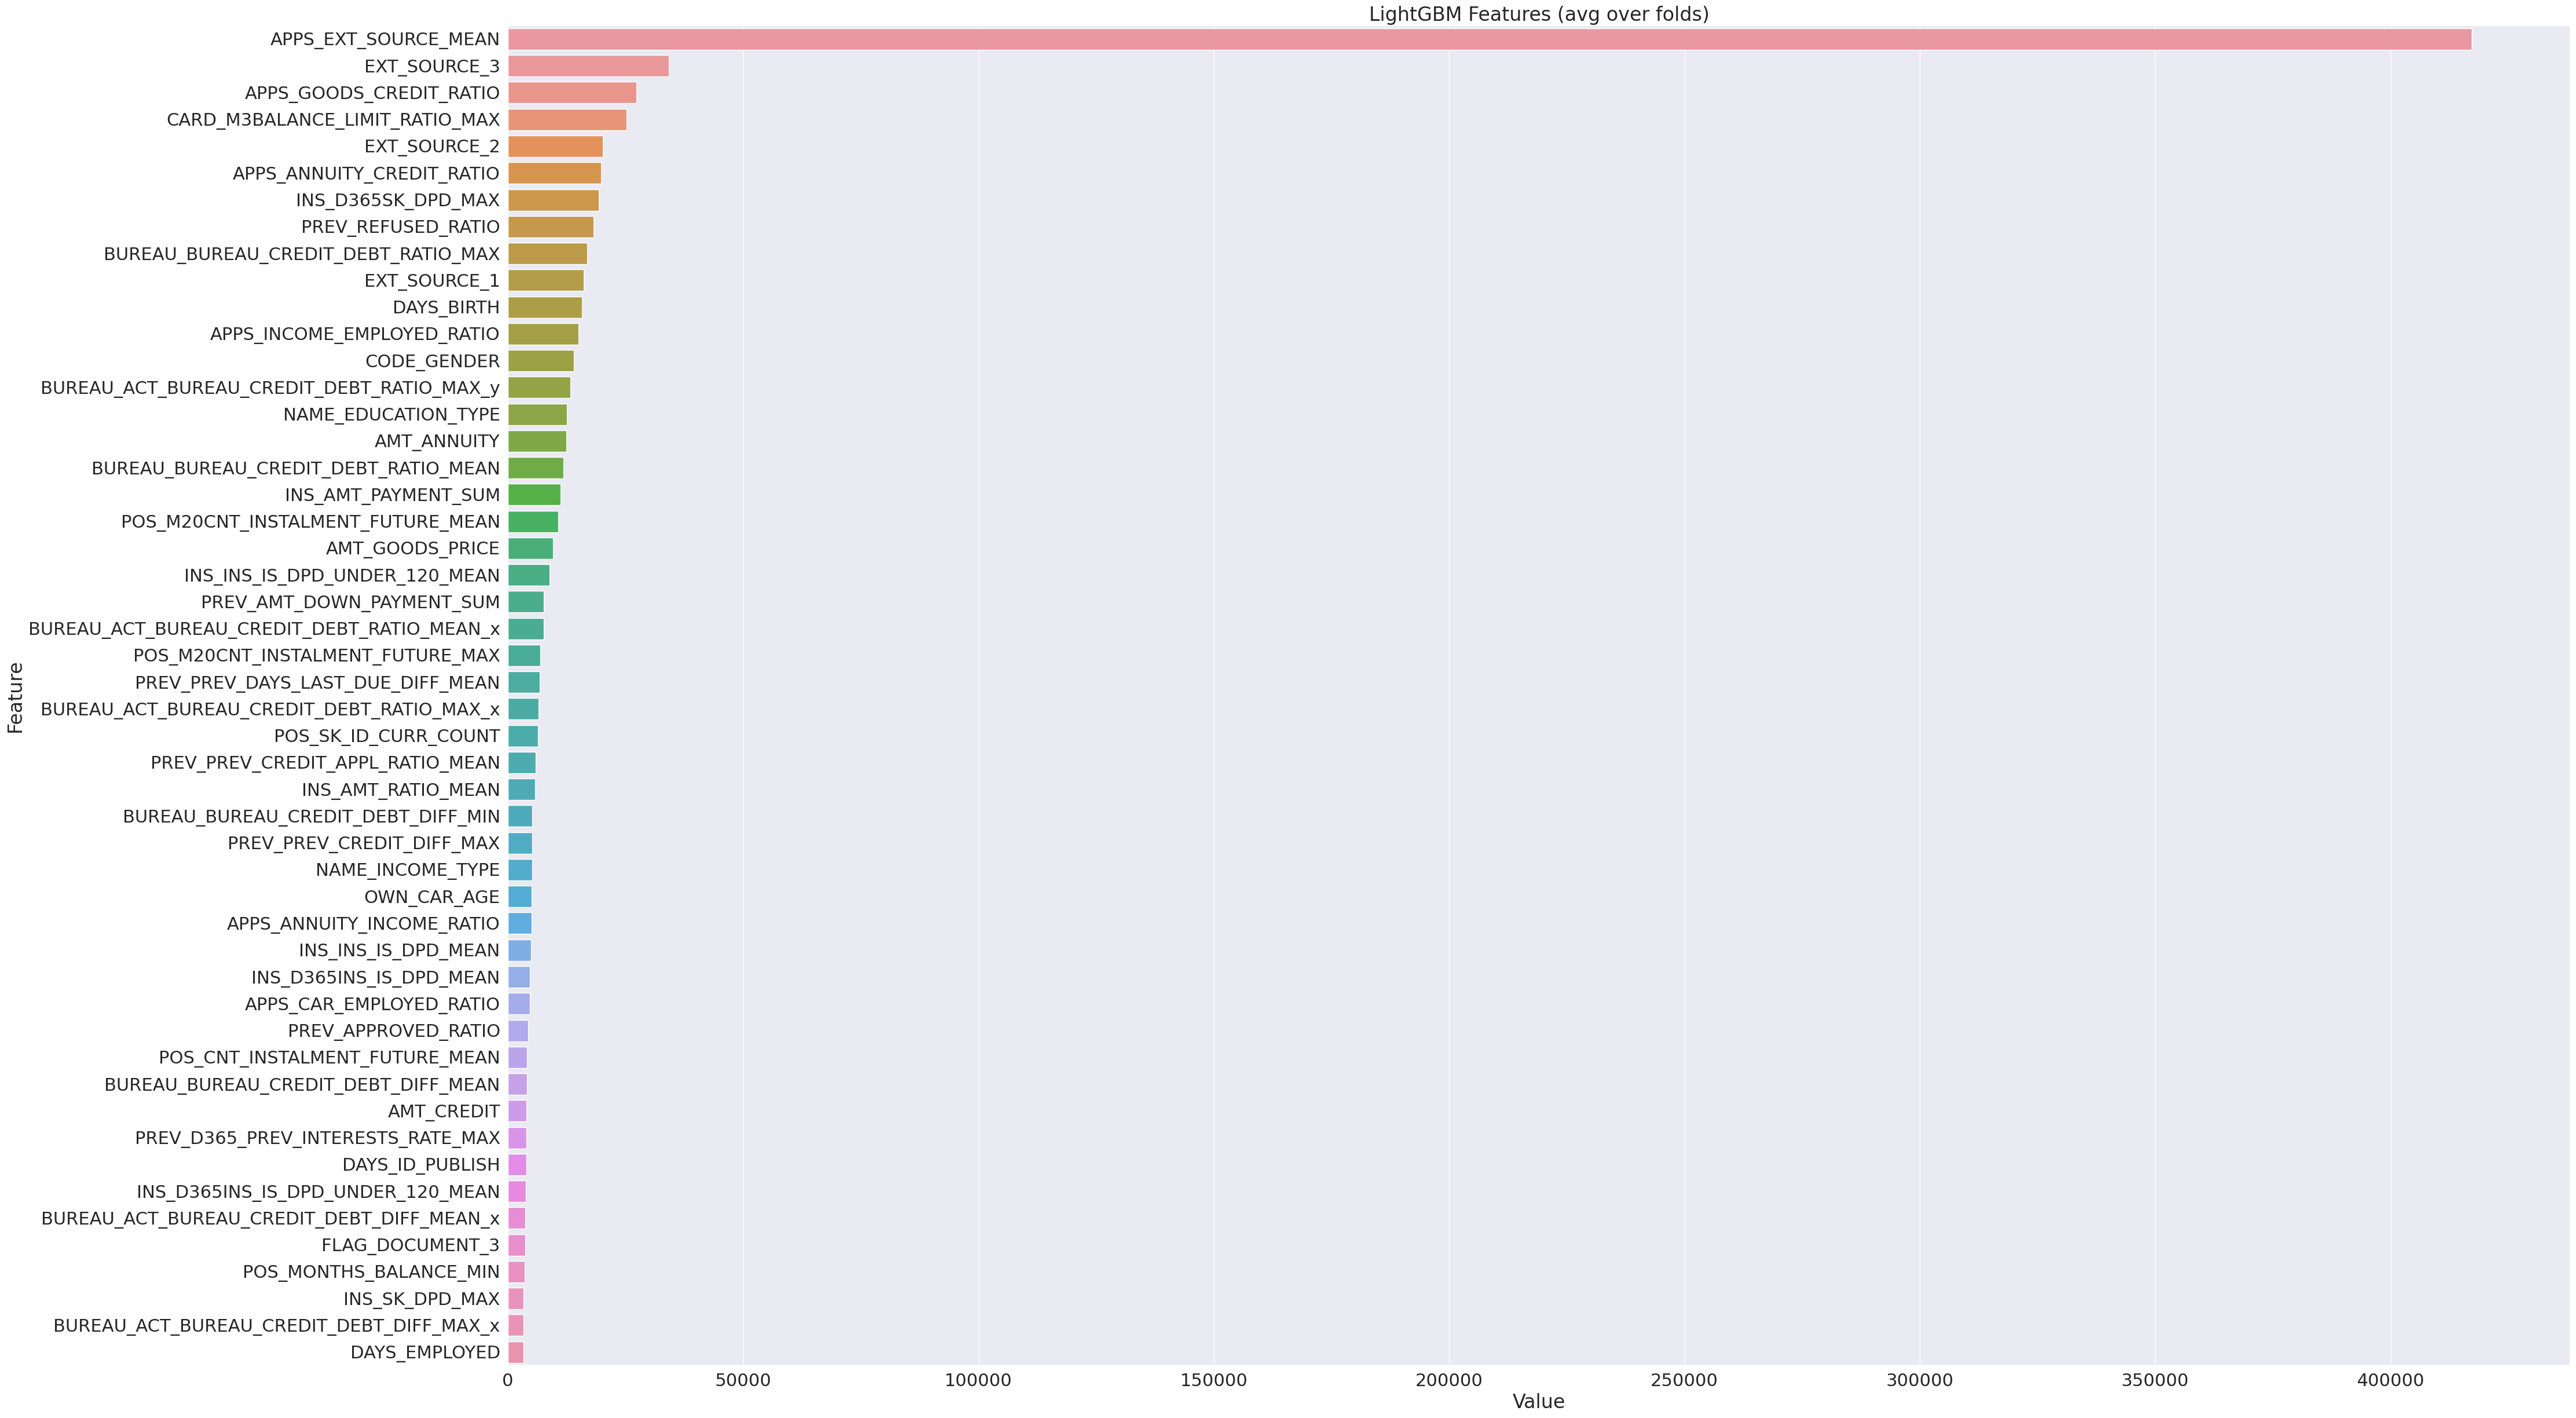

In [ ]:
plotImp(lgb_ver1, num = 50, font_scale= 2)

In [ ]:
df_feature_importance.to_excel('df_feature_importance_lgb_ver1.xlsx')

In [ ]:
test_kaggle = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_test_kaggle_ver2.pkl')
pred = lgb_ver1.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1))

test_kaggle['TARGET'] = pred
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_lgb_ver1.csv', index = False)

# LGBM-ver2

In [ ]:
lgb_train = lgb.Dataset(data=train.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train.TARGET)
lgb_valid = lgb.Dataset(data=valid.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid.TARGET)
lgb_test = lgb.Dataset(data=test.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test.TARGET)

In [ ]:
params = {'task': 'train',
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric': 'auc',
          'learning_rate': 0.018437,
          'num_leaves': 58,
          'max_bin': 300,
          'num_iteration': 1000,
          'colsample_bytree':0.613,
          'subsample':0.708,
          'max_depth':7,
          'reg_alpha':3.564,
          'reg_lambda':4.930,
          'min_split_gain':0.143,
          'min_child_weight':6, 'silent': -1, 'verbose': -1}


lgb_ver2 = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.777861	valid_1's auc: 0.758582
[100]	training's auc: 0.794084	valid_1's auc: 0.769585
[150]	training's auc: 0.806897	valid_1's auc: 0.77612
[200]	training's auc: 0.817303	valid_1's auc: 0.78132
[250]	training's auc: 0.825133	valid_1's auc: 0.784512
[300]	training's auc: 0.831729	valid_1's auc: 0.786916
[350]	training's auc: 0.837784	valid_1's auc: 0.788734
[400]	training's auc: 0.843394	valid_1's auc: 0.790004
[450]	training's auc: 0.848251	valid_1's auc: 0.791029
[500]	training's auc: 0.852789	valid_1's auc: 0.791724
[550]	training's auc: 0.857599	valid_1's auc: 0.792464
[600]	training's auc: 0.862215	valid_1's auc: 0.792943
[650]	training's auc: 0.866741	valid_1's auc: 0.793414
[700]	training's auc: 0.870755	valid_1's auc: 0.793839
[750]	training's auc: 0.874715	valid_1's auc: 0.794386
[800]	training's auc: 0.878329	valid_1's auc: 0.794791
[850]	training'

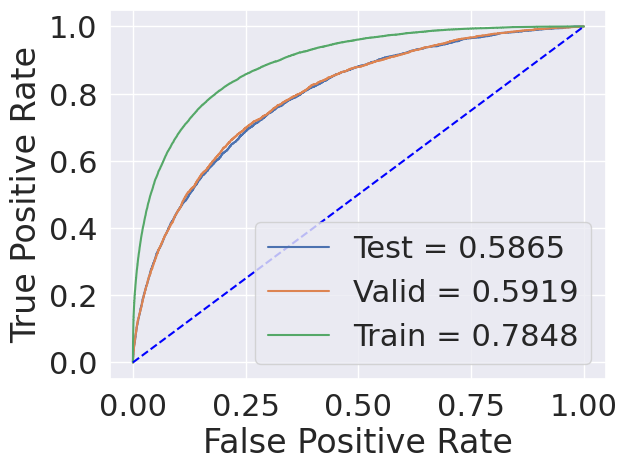

In [ ]:
pred_test = lgb_ver2.predict(test.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_valid = lgb_ver2.predict(valid.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_train = lgb_ver2.predict(train.drop(['SK_ID_CURR', 'TARGET'],axis=1))

plot_roc_curve(true_y = (test['TARGET'], valid['TARGET'], train['TARGET']),
               y_prob = (pred_test, pred_valid, pred_train))

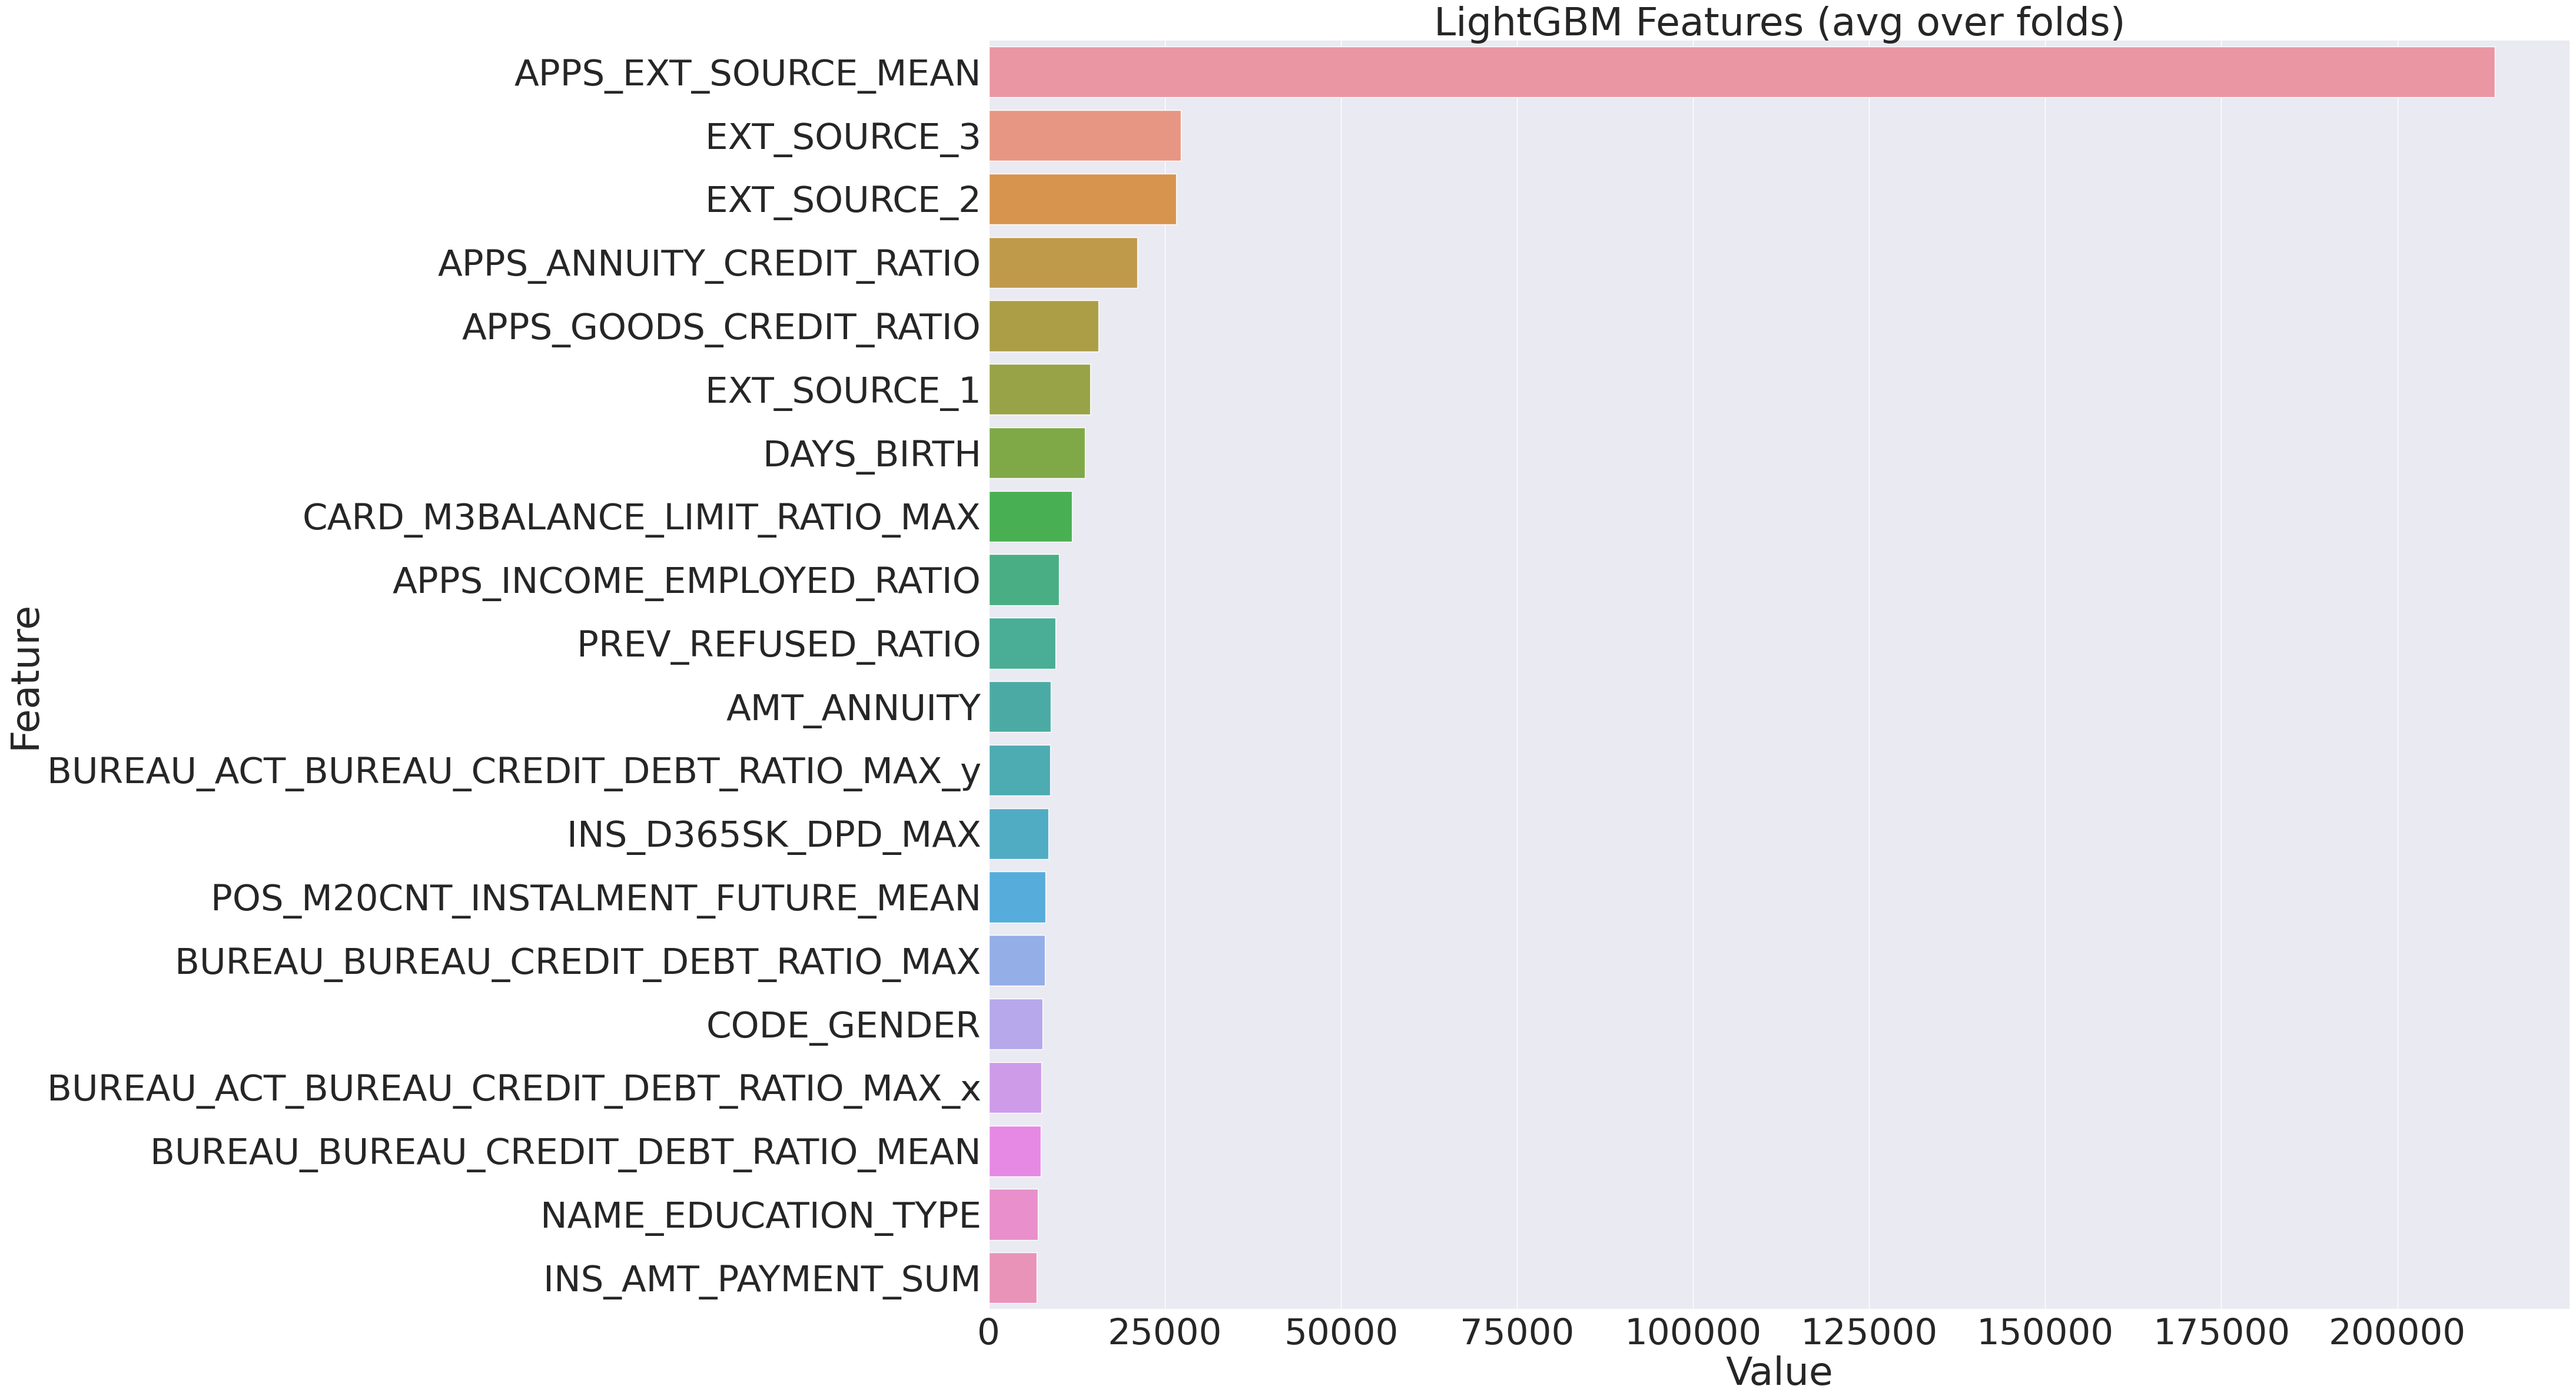

In [ ]:
plotImp(model = lgb_ver2)

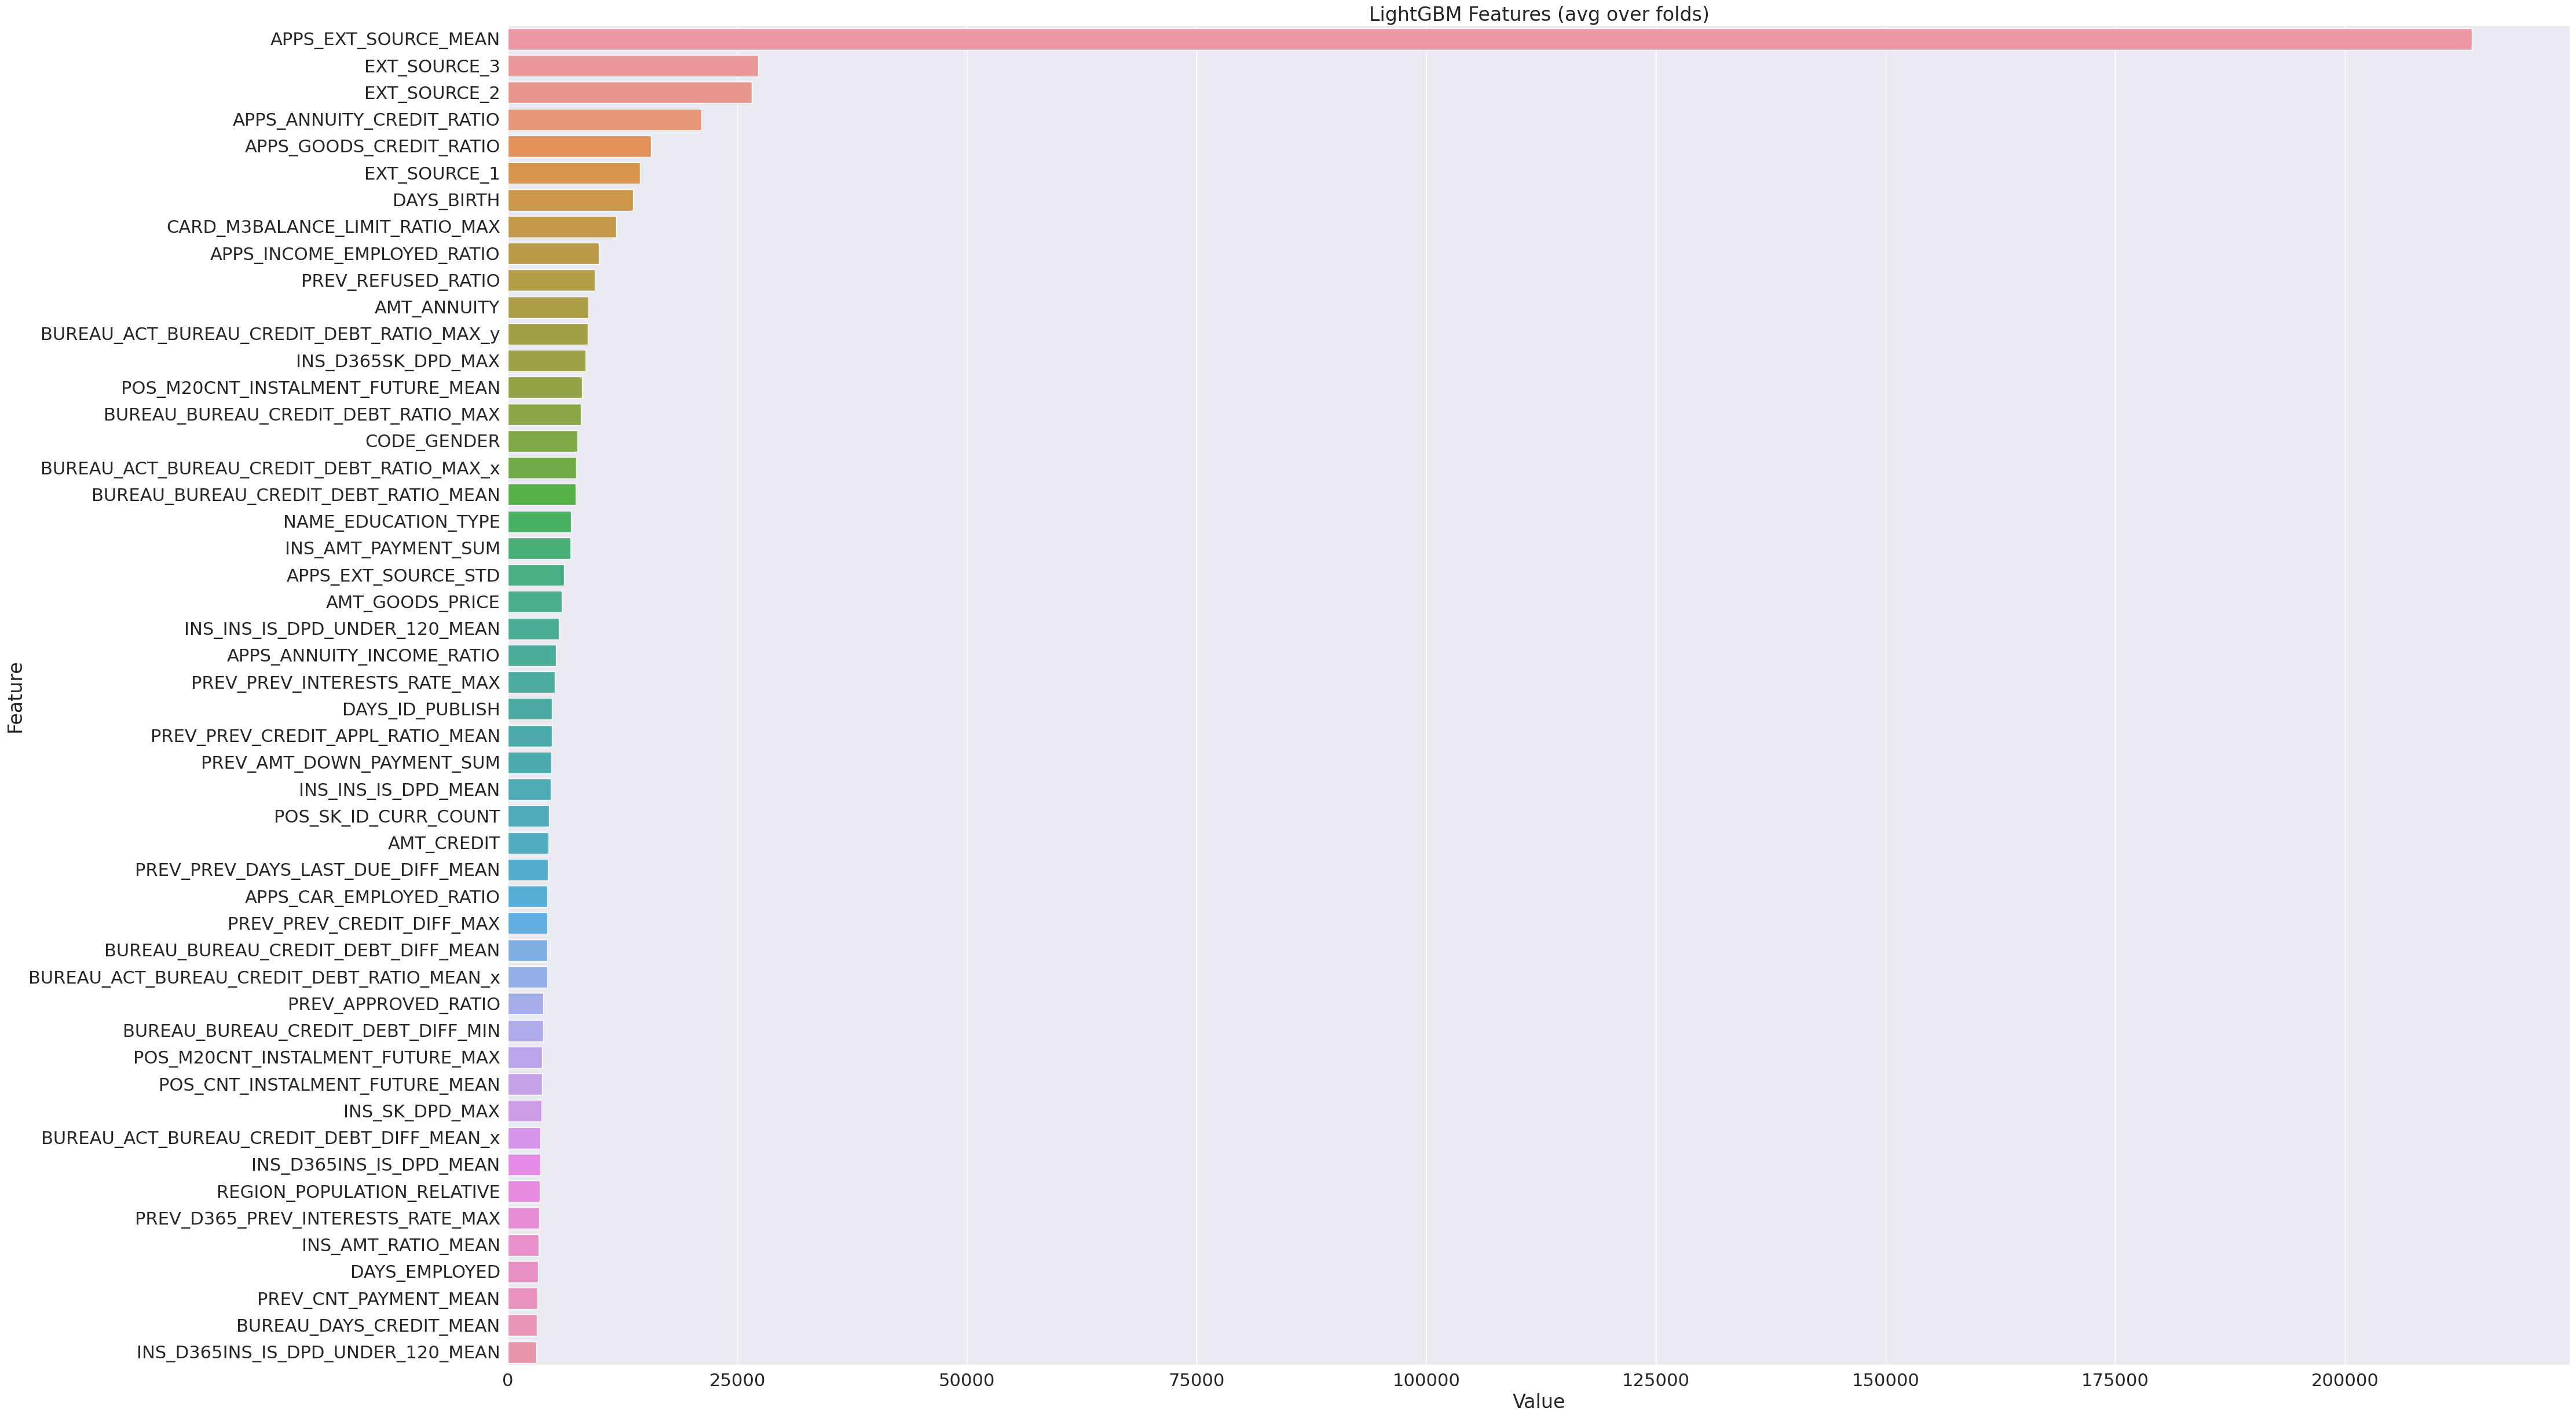

In [ ]:
plotImp(lgb_ver2, num = 50, font_scale = 2)

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': lgb_ver1.feature_name(),
        'importance': lgb_ver1.feature_importance('gain'),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance.sort_values(by = 'importance', ascending=False)

,feature,importance
120,APPS_EXT_SOURCE_MEAN,417323.492845
41,EXT_SOURCE_3,34179.706059
123,APPS_GOODS_CREDIT_RATIO,27273.730509
523,CARD_M3BALANCE_LIMIT_RATIO_MAX,25270.191669
40,EXT_SOURCE_2,20197.420412
...,...,...
263,BUREAU_ACT_CREDIT_DAY_OVERDUE_MIN_x,0.000000
94,FLAG_DOCUMENT_2,0.000000
403,POS_M20POS_IS_DPD_OVER_120_MEAN,0.000000
202,PREV_D365_PREV_GOODS_DIFF_MAX,0.000000


In [ ]:
df_feature_importance.to_excel('df_feature_importance_lgb_ver2.xlsx')

In [ ]:
test_kaggle = pd.read_pickle('/kaggle/input/data-aggregation-ipynb/create_feature_test_kaggle_ver2.pkl')
pred = lgb_ver2.predict(test_kaggle.drop(['SK_ID_CURR'],axis=1))

test_kaggle['TARGET'] = pred
test_kaggle[['SK_ID_CURR', 'TARGET']].to_csv('submission_lgb_ver2.csv', index = False)